In [1]:
import tensorflow as tf
from tensorflow.keras import models,layers
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import pandas as pd

In [2]:
imagesize=256
batchsize=32
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "Plantvillage",
    seed=123,
    shuffle=True,
    image_size=(imagesize,imagesize),
    batch_size=batchsize
)

Found 2152 files belonging to 3 classes.


In [3]:
class_names = dataset.class_names
print("Classes:", class_names)

Classes: ['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']


(32, 256, 256, 3)
[1 1 1 0 0 0 0 0 1 1 1 1 0 1 0 1 1 1 0 1 0 1 0 0 1 0 0 1 1 2 0 0]


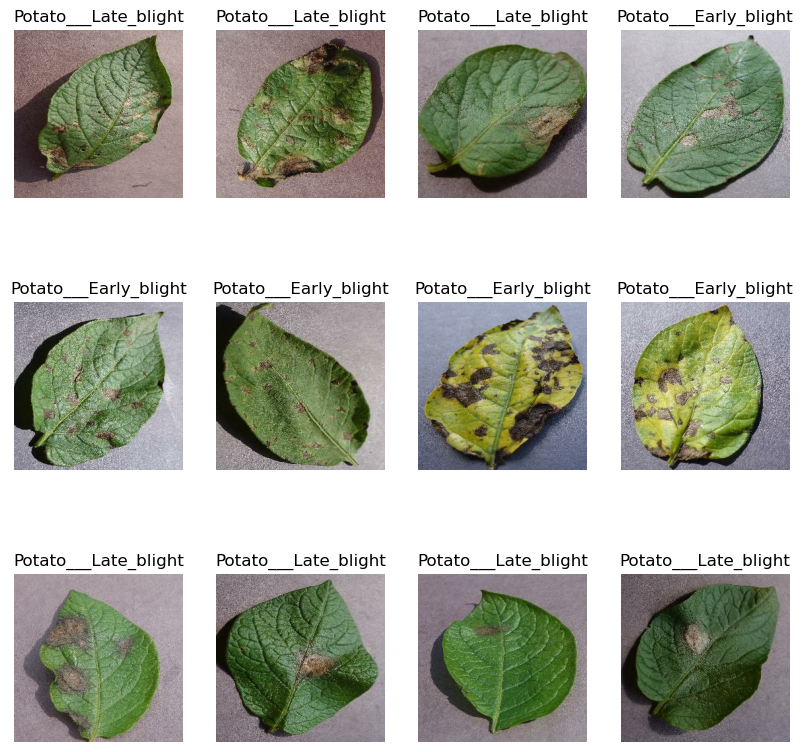

In [4]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")


In [5]:
def split_dataset(dataset, train_ratio=0.8, val_ratio=0.1,test_ratio = 0.1, shuffle=True, shuffle_size=10000):
    assert (train_ratio + test_ratio + val_ratio) == 1
    
    dataset_size = len(dataset)
    if shuffle:
        dataset = dataset.shuffle(shuffle_size, seed=12)
        
    train_size = int(train_ratio * dataset_size)
    val_size = int(val_ratio * dataset_size)

    
    train_ds = dataset.take(train_size)
    val_ds = dataset.skip(train_size).take(val_size)
    test_ds = dataset.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

train_ds, val_ds, test_ds = split_dataset(dataset)
print(f"Train size: {len(train_ds)}, Validation size: {len(val_ds)}, Test size: {len(test_ds)}")

Train size: 54, Validation size: 6, Test size: 8


In [6]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [7]:
resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(imagesize, imagesize),
  layers.Rescaling(1./255),
])

In [8]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomContrast(0.2)
])
train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y)).prefetch(buffer_size=tf.data.AUTOTUNE)

In [27]:
channels = 3
input_shape = (imagesize, imagesize, channels)
n_classes = 3

from tensorflow.keras.applications import VGG19
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
checkpoint_path = "best_vgg19_model.keras"

vgg19_base = VGG19(weights='imagenet', include_top=False, input_shape=input_shape)
for layer in vgg19_base.layers:
    layer.trainable = False


vgg_model = models.Sequential([
    resize_and_rescale,
    vgg19_base,
    layers.GlobalAveragePooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(n_classes, activation='softmax')
])
vgg_model.build(input_shape=(None, imagesize, imagesize, 3))


In [28]:
vgg_model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ vgg19 (Functional)                   │ (None, 8, 8, 512)           │      20,024,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 20,090,435 (76.64 MB)

 Trainable params: 66,051 (258.01 KB)

 Non-trainable params: 20,024,384 (76.39 MB)

In [29]:
vgg_model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [30]:
#callbacks1 = [
    #ModelCheckpoint(checkpoint_path, monitor='val_accuracy', save_best_only=True, verbose=1),
    #EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
#]

In [31]:
history = vgg_model.fit(
    train_ds,
    batch_size=batchsize,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
    #callbacks=callbacks1
)

Epoch 1/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 173s 3s/step - accuracy: 0.5965 - loss: 0.8730 - val_accuracy: 0.8021 - val_loss: 0.6148
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 171s 3s/step - accuracy: 0.8205 - loss: 0.5479 - val_accuracy: 0.8333 - val_loss: 0.4705
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 170s 3s/step - accuracy: 0.8552 - loss: 0.4142 - val_accuracy: 0.8646 - val_loss: 0.3763
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 170s 3s/step - accuracy: 0.8787 - loss: 0.3314 - val_accuracy: 0.8646 - val_loss: 0.3152
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 171s 3s/step - accuracy: 0.8897 - loss: 0.3144 - val_accuracy: 0.8385 - val_loss: 0.3516
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 171s 3s/step - accuracy: 0.8862 - loss: 0.2832 - val_accuracy: 0.9479 - val_loss: 0.2247
Epoch 7/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 170s 3s/step - accuracy: 0.9137 - loss: 0.2590 - val_accuracy: 0.9375 - val_loss: 0.2159
Epoch 8/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 170s 3s/step - accuracy: 0.9200 - loss: 0.2179 - val_accuracy: 0.9583 - v

In [32]:
scores = vgg_model.evaluate(test_ds)

8/8 ━━━━━━━━━━━━━━━━━━━━ 23s 3s/step - accuracy: 0.9681 - loss: 0.1215


In [33]:
def plot_training_history(history, title='Model Performance'):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc)+1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'g', label='Train Acc')
    plt.plot(epochs, val_acc, 'b', label='Val Acc')
    plt.title(f'{title} - Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'r', label='Train Loss')
    plt.plot(epochs, val_loss, 'orange', label='Val Loss')
    plt.title(f'{title} - Loss')
    plt.legend()
    plt.show()

In [34]:
def plot_training_history(history, title='Model Performance'):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc)+1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'g', label='Train Acc')
    plt.plot(epochs, val_acc, 'b', label='Val Acc')
    plt.title(f'{title} - Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'r', label='Train Loss')
    plt.plot(epochs, val_loss, 'orange', label='Val Loss')
    plt.title(f'{title} - Loss')
    plt.legend()
    plt.show()

In [35]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score, precision_score, recall_score, f1_score
def plot_confusion_matrix(model, dataset, class_names):
    y_true, y_pred = [], []

    for images, labels in dataset:
        preds = model.predict(images)
        preds = np.argmax(preds, axis=1)
        y_true.extend(labels.numpy())
        y_pred.extend(preds)

    cm = confusion_matrix(y_true, y_pred)
    ConfusionMatrixDisplay(cm, display_labels=class_names).plot(cmap='Blues')
    plt.title("Confusion Matrix")
    plt.show()

    print("\n Classification Report:")
    report = classification_report(y_true, y_pred, target_names=class_names)
    print(report)
    
    acc = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')

    print(f"Accuracy:  {acc:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1 Score:  {f1:.4f}")

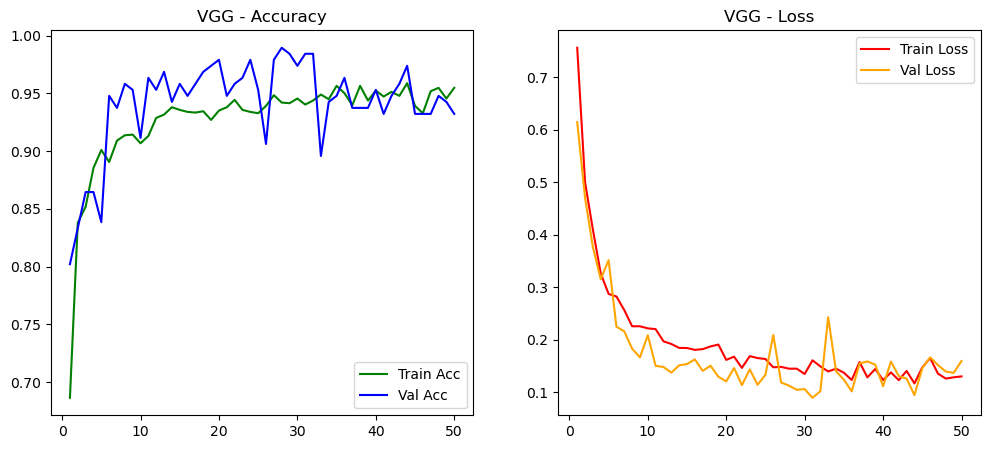

In [36]:
class_names = ["Early Blight", "Late Blight", "Healthy"]
plot_training_history(history, title="VGG")

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


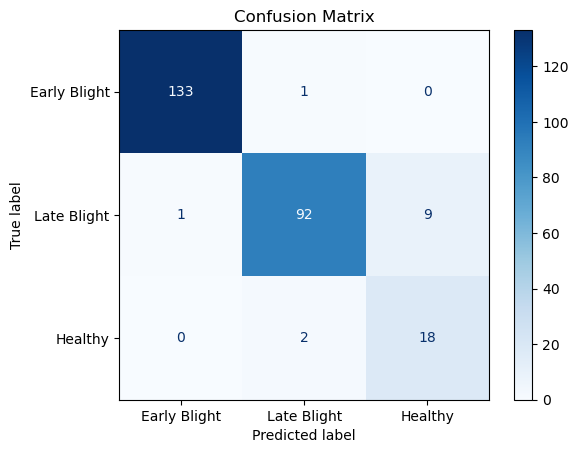


 Classification Report:
              precision    recall  f1-score   support

Early Blight       0.99      0.99      0.99       134
 Late Blight       0.97      0.90      0.93       102
     Healthy       0.67      0.90      0.77        20

    accuracy                           0.95       256
   macro avg       0.88      0.93      0.90       256
weighted avg       0.96      0.95      0.95       256

Accuracy:  0.9492
Precision: 0.9575
Recall:    0.9492
F1 Score:  0.9515


In [37]:
plot_confusion_matrix(vgg_model, test_ds, class_names)

first image to predict
actual label: Early Blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
predicted label: Early Blight


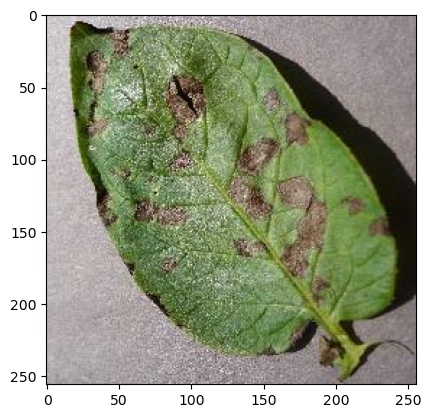

In [38]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = vgg_model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [39]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 498ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step


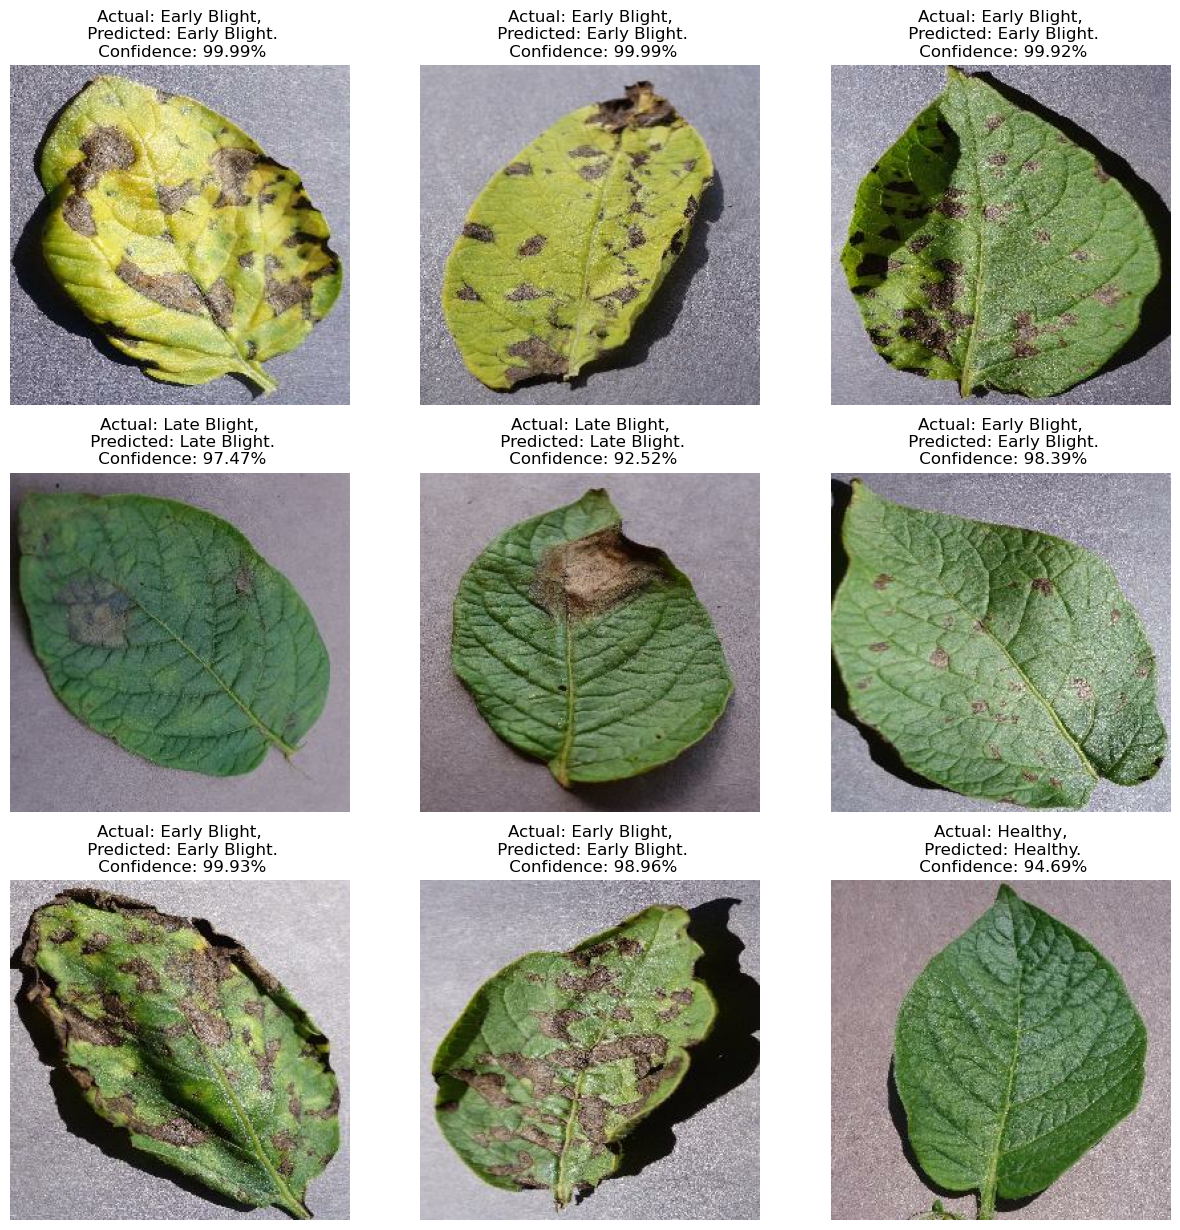

In [40]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(vgg_model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [41]:
vgg_model.save("VGG1.h5")

In [12]:
from tensorflow.keras.models import load_model
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf


model = load_model("VGG1.h5",compile=False)


class_names = ["Early Blight", "Late Blight", "Healthy"]

def load_and_preprocess_image(path, target_size=(256, 256)):
    image = Image.open(path).convert('RGB')
    image = image.resize(target_size)
    img_array = np.array(image) 
    img_array = np.expand_dims(img_array, axis=0)
    return img_array, image

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step


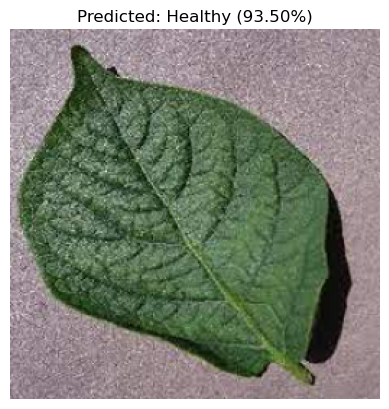

In [14]:
image_path ="C:/Users/subha/Downloads/1.jpg"
img_array, original_image = load_and_preprocess_image(image_path)

predictions = model.predict(img_array)
predicted_class = np.argmax(predictions, axis=1)[0]
confidence = np.max(predictions)

plt.imshow(original_image)
plt.axis('off')
plt.title(f"Predicted: {class_names[predicted_class]} ({confidence*100:.2f}%)")
plt.show()